In [1]:
import umap.aligned_umap
import numpy as np
import matplotlib.pyplot as plt
import torch
import os

/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-28 11:49:25.399545: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 11:49:25.966356: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-09-28 11:49:25.966407: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinf

In [2]:
path1 = "/home/yifan/dataset/clean/pairflip/cifar10/0"
path2 = "/home/yifan/Exp/Dropout/0.3/experiment1"

In [3]:
def getData(path,epoch):
    ##### get representation
    X_train = np.load(os.path.join(path,"Model","Epoch_{}".format(epoch),"train_data.npy"))
    X_test = np.load(os.path.join(path,"Model","Epoch_{}".format(epoch),"test_data.npy"))
    
    #### get label
    training_label_loc =  os.path.join(path, "Training_data", "training_dataset_label.pth")
    y_train = torch.load(training_label_loc, map_location="cpu")
    y_train = y_train.numpy()
    testing_label_loc =  os.path.join(path, "Testing_data", "testing_dataset_label.pth") 
    y_test = torch.load(testing_label_loc, map_location="cpu")
    y_test = y_test.numpy()

    return X_train, X_test, y_train, y_test


In [4]:
X_train1, X_test1, y_train1, y_test1 = getData(path1,150)
X_train2, X_test2, y_train2, y_test2 = getData(path2,150)

In [5]:
##### 
X_train = X_train1.reshape(X_train1.shape[0],X_train1.shape[1])
y_train= y_train2

In [17]:
np.random.seed(23423)
nA = 3000
nRest = 6000
#set_up_parameters

epochs = 200
n_neighbors= 30
n_components = 2
MIN_DIST = 0.1
neg_sample_rate = 5
n = X_train.shape[0]
    


%load_ext autoreload
%autoreload 2

np.random.seed(23423)

rand_perm = np.random.permutation(n)

X_train_rp = X_train
y_train_rp = y_train
print(X_train_rp.shape)

X_train200, _, y_train200, _ = getData(path1,200)
X_train150, _, y_train150, _ = getData(path1,150)
X_train100, _, y_train100, _ = getData(path1,100)
X_train50, _, y_train50, _ = getData(path1,50)
X_train1, _, y_train1, _ = getData(path1,1)
X_train50 = X_train50.reshape(X_train50.shape[0],X_train50.shape[1] )
X_train1 = X_train1.reshape(X_train1.shape[0],X_train1.shape[1] )


X2_train200, _, y2_train200, _ = getData(path2,200)
X2_train200 = X2_train200.reshape(X2_train200.shape[0],X2_train200.shape[1] )



X_train_rp = X_train200[:(nA +nRest )] 
y_train_rp = y_train200[:(nA +nRest )] 



X_train_rp = np.concatenate((X_train_rp, X2_train200[:nRest]),axis=0)
y_train_rp = np.concatenate((y_train_rp, y2_train200[:nRest]),axis=0)

# X_train_rp = np.concatenate((X_train_rp, X_train100[:nRest]),axis=0)
# y_train_rp = np.concatenate((y_train_rp, y_train100[:nRest]),axis=0)

# X_train_rp = np.concatenate((X_train_rp, X_train50[:nRest]),axis=0)
# y_train_rp = np.concatenate((y_train_rp, y_train50[:nRest]),axis=0)

# X_train_rp = np.concatenate((X_train_rp, X_train1[:nRest]),axis=0)
# y_train_rp = np.concatenate((y_train_rp, y_train1[:nRest]),axis=0)



SETA = X_train_rp[:nA]
y_SETA = y_train_rp[:nA]

SETS = []
y_SETS = []
DATA = []

N_DATA = []

for i in range(2):
    pass
    print('in loop')
    
    setb = X_train_rp[nA+nRest*i:nA+nRest*(i+1)]
    y_setb = y_train_rp[nA+nRest*i:nA+nRest*(i+1)]
    data = np.concatenate((SETA,setb))
    N_DATA.append(data.shape[0])
    
    SETS.append(setb)
    y_SETS.append(y_setb)
    DATA.append(data)

    
print('out of loop')    

SETS = np.array(SETS)
DATA = np.array(DATA)
N_DATA = np.array(N_DATA)

n_SET = SETS.shape[0]

print(SETA.shape, SETS.shape, SETS[0].shape, DATA.shape, n_SET)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(50000, 512)
in loop
in loop
out of loop
(3000, 512) (2, 6000, 512) (6000, 512) (2, 9000, 512) 2


In [18]:
from MANE import *

GRAPHS = []
ROWS = []
COLUMNS = []
WEIGHTS = []
EPOCHS_PER_SAMPLE = []
EPOCH_OF_NEXT_SAMPLE = []
EPOCHS_PER_NEGATIVE_SAMPLE = []
EPOCH_OF_NEXT_NEGATIVE_SAMPLE = []

SET_IDX = []
K_IDX = []

for iset in range(n_SET):
    graph = get_prob_matrix(DATA[iset],n_neighbors=n_neighbors)
    graph.data[graph.data < (graph.data.max() / float(epochs))] = 0.0
    graph.eliminate_zeros()
    
    epochs_per_sample = make_epochs_per_sample(graph.data, epochs)
    epoch_of_next_sample = epochs_per_sample.copy()
    epochs_per_negative_sample = epochs_per_sample / neg_sample_rate
    epoch_of_next_negative_sample = epochs_per_negative_sample.copy()
    
    set_idx = iset*np.ones(len(epochs_per_sample),dtype=np.int)
    k_idx = np.arange(epochs_per_sample.shape[0],dtype=np.int)
    
    SET_IDX.append(set_idx)
    K_IDX.append(k_idx)
    
    ROWS.append(graph.row)
    COLUMNS.append(graph.col)
    EPOCHS_PER_SAMPLE.append(epochs_per_sample)
    EPOCH_OF_NEXT_SAMPLE.append(epoch_of_next_sample)
    EPOCHS_PER_NEGATIVE_SAMPLE.append(epochs_per_negative_sample)
    EPOCH_OF_NEXT_NEGATIVE_SAMPLE.append(epoch_of_next_negative_sample)
    
    print(epochs_per_sample.shape)
print(SET_IDX)



SET_IDX = np.array(np.concatenate(SET_IDX)).reshape(-1)
K_IDX = np.array(np.concatenate(K_IDX)).reshape(-1)

n_idx = np.random.permutation(len(SET_IDX))
SET_IDX = SET_IDX[n_idx]
K_IDX = K_IDX[n_idx]

print('done')

Processed  1000  of  9000  samples.
Processed  2000  of  9000  samples.
Processed  3000  of  9000  samples.
Processed  4000  of  9000  samples.
Processed  5000  of  9000  samples.
Processed  6000  of  9000  samples.
Processed  7000  of  9000  samples.
Processed  8000  of  9000  samples.
Processed  9000  of  9000  samples.


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, chec

(406354,)
Processed  1000  of  9000  samples.
Processed  2000  of  9000  samples.
Processed  3000  of  9000  samples.
Processed  4000  of  9000  samples.
Processed  5000  of  9000  samples.
Processed  6000  of  9000  samples.
Processed  7000  of  9000  samples.
Processed  8000  of  9000  samples.
Processed  9000  of  9000  samples.
(391832,)
[array([0, 0, 0, ..., 0, 0, 0]), array([1, 1, 1, ..., 1, 1, 1])]
done


Hyperparameters a = 1.5769434604035877 and b = 0.8950608780665811


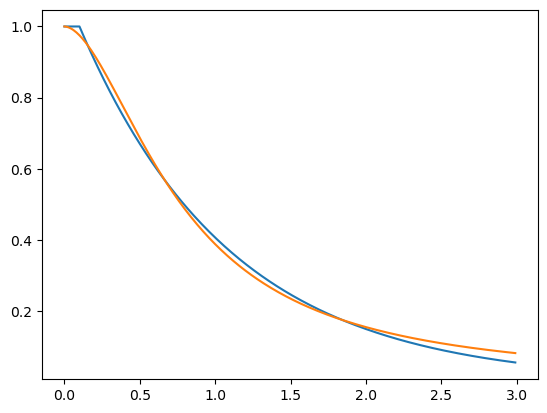

In [19]:
from scipy import optimize
x = np.linspace(0, 3, 300)

y = (x>MIN_DIST) * np.exp(-x+MIN_DIST)
y[x<=MIN_DIST] = 1.0

function = lambda x, a, b: 1 / (1 + a*x**(2*b))

p , _ = optimize.curve_fit(function, x, y) 

a = p[0]
b = p[1] 
print("Hyperparameters a = " + str(a) + " and b = " + str(b))

x_p = np.arange(0,3,0.01)
y_p = np.exp(- (x_p-MIN_DIST) * ( (x_p - MIN_DIST) >=0 ) )
y_p2 = 1 / (1 + a*x_p**(2*b))

plt.figure()
plt.plot(x_p,y_p, label='Target')
plt.plot(x_p,y_p2, label='Fitted')
plt.show()

In [86]:
SETA.shape

(3000, 512)

In [20]:
from sklearn.decomposition import PCA

n_components = 2

pca = PCA(n_components = n_components)
init = pca.fit_transform(SETA)
embA = init.astype(np.float32).copy()
expansion = 10.0 / np.abs(embA).max()
embA = (embA * expansion).astype(np.float32)

emb_sets = []

print('before initi')

for i in range(n_SET):
    data = DATA[i]
    emb_i = pca.transform(data[nA:])
    emb_i = (emb_i * expansion).astype(np.float32)
    
    emb_sets.append(emb_i)
    
print('after init')

repulsion_strength=1.0

init_lr = 1.0

#SET_IDX
#K_IDX

print(len(EPOCH_OF_NEXT_NEGATIVE_SAMPLE))
print(EPOCH_OF_NEXT_NEGATIVE_SAMPLE[0].shape)

import timeit

for epoch in range(epochs):
    pass
    
    if epoch%20==0:
        print('epoch ', epoch, 'of ', epochs)
    #print('epoch ', epoch, 'of ', epochs)
    start = timeit.default_timer()
    
    lr = init_lr * (1.0 - float(epoch)/float(epochs))
    
    #'''
    one_epoch_nsets(emCommon=embA, embS=emb_sets,
                     rows=ROWS, columns=COLUMNS,
                     nCommon=nA, n_points_=N_DATA,
                     Set=SET_IDX, K_idx=K_IDX,
                     a=a, b=b, dim=n_components,
                     lr=lr, epoch=epoch,
                     epochs_per_sample=EPOCHS_PER_SAMPLE,
                     epoch_of_next_sample=EPOCH_OF_NEXT_SAMPLE,
                     epochs_per_negative_sample=EPOCHS_PER_NEGATIVE_SAMPLE,
                     epoch_of_next_negative_sample=EPOCH_OF_NEXT_NEGATIVE_SAMPLE,
                     repulsion_strength=repulsion_strength)
    #'''
    stop = timeit.default_timer()
    print('Time for epoch ', epoch, ': ', stop - start) 

before initi
after init
2
(406354,)
epoch  0 of  200
Time for epoch  0 :  0.0772856529802084
Time for epoch  1 :  0.08240892179310322
Time for epoch  2 :  0.09050255455076694
Time for epoch  3 :  0.08227263391017914
Time for epoch  4 :  0.08324285596609116
Time for epoch  5 :  0.08417014963924885
Time for epoch  6 :  0.08673165924847126
Time for epoch  7 :  0.0870011355727911
Time for epoch  8 :  0.0891012717038393
Time for epoch  9 :  0.0900832824409008
Time for epoch  10 :  0.09141256287693977
Time for epoch  11 :  0.09319240041077137
Time for epoch  12 :  0.09248782508075237
Time for epoch  13 :  0.09397072903811932
Time for epoch  14 :  0.09486041963100433
Time for epoch  15 :  0.09275886416435242
Time for epoch  16 :  0.09311002679169178
Time for epoch  17 :  0.09319992735981941
Time for epoch  18 :  0.09366449527442455
Time for epoch  19 :  0.09306866861879826
epoch  20 of  200
Time for epoch  20 :  0.0931763518601656
Time for epoch  21 :  0.09576055034995079
Time for epoch  22 :

(3000, 2)


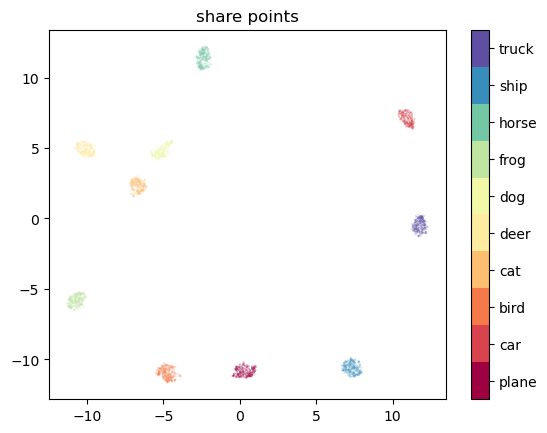

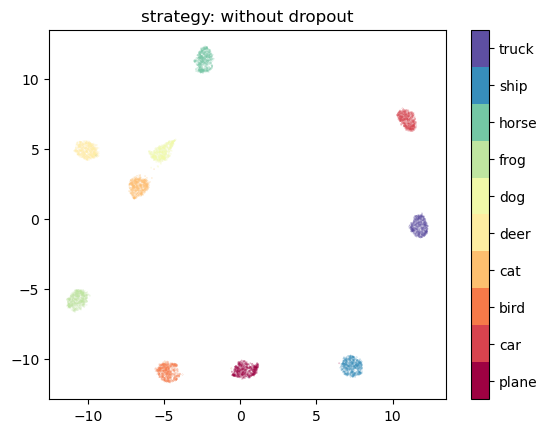

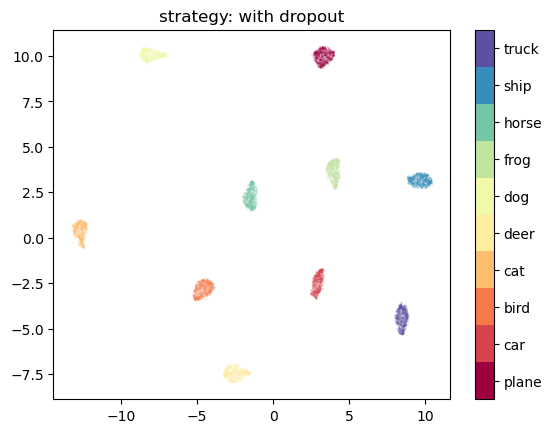

In [22]:
%matplotlib inline


classes= ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

plt.figure()
plt.title('share points')
print(embA.shape)
plt.scatter(embA[:,0], embA[:,1], c=y_SETA, s=0.01, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

epochclist = ['without dropout','with dropout']

for i in range(n_SET):

    plt.figure()
    plt.title('strategy: {}'.format(epochclist[i]))
    embB = emb_sets[i]
    y_embB = y_SETS[i]
    plt.scatter(embB[:,0], embB[:,1], c=y_embB, s=0.01, cmap='Spectral')
    cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
    cbar.set_ticks(np.arange(10))
    cbar.set_ticklabels(classes)
